# Vorhersage des Ödometer-Versuchs mit einem neuronalen Netzwerk

**Ziel:**
Entwicklung eines neuronalen Netzes, das auf Basis gegebener Input-Parameter den Elastizitätsmodul $E_s$ im Ödometer-Versuch vorhersagt.

---

## 1. Problemformulierung

Es wird folgende Beziehung zugrunde gelegt:

$$
\dot{\sigma} = C_1\,\sigma_t\,\dot{\varepsilon} + C_2\,\sigma_t\,\left|\dot{\varepsilon}\right|
$$

Diese Gleichung beschreibt die Änderung der Spannung $\dot{\sigma}$ in Abhängigkeit von der aktuellen Spannung $\sigma_t$, der Dehnungsrate $\dot{\varepsilon}$ und den Koeffizienten $C_1, C_2$, die aus dem gewählten Modell abgeleitet sind.

---

## 2. Annahmen / Startwerte

Die Berechnung basiert auf folgenden festen Parametern:

- **Startspannung:** $\sigma_0 = -10{,}00\,\text{kPa}$
- **Porenverhältnis:** $e_0 = 1{,}00$
- **Koeffizienten:**
  - $C_c = 0{,}005$
  - $C_s = 0{,}002$
- **Dehnungsraten:**
  - Stauchungsphase: $\dot{\varepsilon}_c = -0{,}0005$
  - Dehnungsphase: $\dot{\varepsilon}_e = +0{,}0005$

---

## 3. Trainingssetup

- **Input:**
  $\sigma_t$, $\dot{\varepsilon}$
- **Output:**
  Elastizitätsmodul $E_s$

Das neuronale Netz soll aus den aktuellen Zustandsgrößen ($\sigma_t$, $\dot{\varepsilon}$) lernen, in welcher Phase (Kompression vs. Entlastung) sich der Versuch befindet, und darauf basierend $E_s$ schätzen.

---

## 4. Variablendeklaration

| Symbol              | Variable im Code     | Bedeutung |
|---------------------|----------------------|-----------|
| $\sigma_t$          | `sigma_t`            | Aktuelle Spannung zum Zeitpunkt $t$ |
| $\dot{\varepsilon}$ | `delta_epsilon`      | Dehnungsrate; negative Werte: Kompression, positive: Entlastung |
| $\dot\sigma_t$      | `delta_sigma`        | Inkrementelle Änderung der Spannung |
| $E_s$               | `e_s`                | Elastizitätsmodul (Zielgröße) |
| $e_0$               | `e_0`                | Porenverhältniszahl |

---

## 5. Hinweise zur Phase

Die Phase (Stauchung vs. Dehnung) lässt sich über das Vorzeichen von $\dot{\varepsilon}$ ablesen. Alternativ kann explizit ein Zustandsindikator (z. B. one-hot oder diskrete Labels für Belastung/Entlastung) zusätzlich als Feature mitgegeben werden, um dem Modell das Unterscheiden zu erleichtern.


# Grundparameter

In [29]:
from random import randint

# Define input and output parameters
input_str = "sigma_t"
output_str = "e_s"

# 0 : simple, 1 : improved
oedo_model = 1

# Defining problem parameters
amount_trainings_data = 1

# Data preparation
oedo_para = {
    "e0":1,
    "c_c":0.005,
    "c_s":0.002,
    "sigma_prime_p":-1,
    "sigma_max":-1000,  # kPa
    "sigma_min":-100,   # kPa
    "eps_delta":-0.0005,
    "eps_0":0,
}

# Load problem and generate trainings

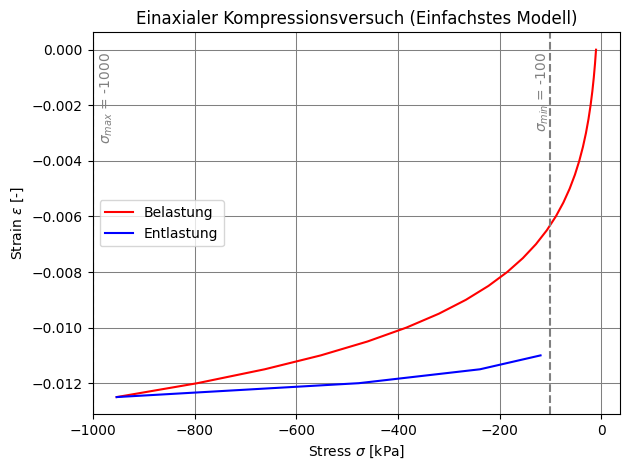

In [43]:
from random import sample
import torch
if oedo_model == 0:
    from classes.classOedometerSimple import Oedometer
else:
    from classes.classOedometerImproved import Oedometer
sigma_t_train =  [-10] #sample(range(-amount_trainings_data * 2,0), amount_trainings_data)

list_output = []
dict_input = {'input1' : [], 'input2' : []}
for i in range(amount_trainings_data):
    oedo = Oedometer(sigma_prime_p=sigma_t_train[i])
    oedo.run()
    list_output += oedo.e_s_list
    dict_input['input1'] += oedo.sigma_0_list
    dict_input['input2'] += oedo.eps_delta_list

oedo.plot()


tensor_input1 = torch.tensor(dict_input['input1'], dtype=torch.float)  # (B, L)
tensor_input2 = torch.tensor(dict_input['input2'], dtype=torch.float)  # (B, L)

if tensor_input1.shape != tensor_input2.shape:
    raise ValueError(f"Input-Shapes mismatch: {tensor_input1.shape} vs {tensor_input2.shape}")

tensor_input = torch.stack((tensor_input1, tensor_input2), dim=-1)
tensor_output = torch.tensor(list_output, dtype=torch.float)          # (B, L)
tensor_output = tensor_output.unsqueeze(-1)  # (B, L, 1)

# Show trainingsdata (List) as DataFrame
Type `list`: `list_input` and `list_output`

In [48]:
import pandas as pd

df = pd.DataFrame([['sigma_t'] + dict_input['input1'], ['eps_delta'] + dict_input['input2'], [output_str] + list_output])
display(df)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,sigma_t,-10.0000,-12.0000,-14.4000,-17.2800,-20.7360,-24.8832,-29.85984,-35.831808,-42.99817,...,-319.479999,-383.375999,-460.051199,-552.061439,-662.473727,-794.968472,-953.962166,-476.981083,-238.490542,-119.245271
1,eps_delta,-0.0005,-0.0005,-0.0005,-0.0005,-0.0005,-0.0005,-0.00050,-0.000500,-0.00050,...,-0.000500,-0.000500,-0.000500,-0.000500,-0.000500,-0.000500,0.000500,0.000500,0.000500,0.000500
2,e_s,4000.0000,4800.0000,5760.0000,6912.0000,8294.4000,9953.2800,11943.93600,14332.723200,17199.26784,...,127791.999748,153350.399698,184020.479637,220824.575565,264989.490678,317987.388814,381584.866576,476981.083220,238490.541610,119245.270805


# Show trainingsdata (Tensor) as DataFrame
Type `tensor`: `tensor_input` and `tensor_output`

In [49]:
import torch

tensor_input_df = pd.DataFrame(
    torch.cat((tensor_input, tensor_output), dim=1), columns=[input_str, 'eps_delta', output_str]
)
display(tensor_input_df)

,sigma_t,eps_delta,e_s
0,-10.000000,-0.0005,4000.000000
1,-12.000000,-0.0005,4800.000000
2,-14.400000,-0.0005,5760.000000
3,-17.280001,-0.0005,6912.000000
4,-20.736000,-0.0005,8294.400391
5,-24.883200,-0.0005,9953.280273
6,-29.859840,-0.0005,11943.935547
7,-35.831806,-0.0005,14332.723633
8,-42.998169,-0.0005,17199.267578
9,-51.597805,-0.0005,20639.121094


# Define SimpleRegressor Model

In [33]:
import torch.nn as nn

class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        return self.linear(x)


model = SimpleRegressor()

# Training

In [34]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.1)

epochs = 100000
loss_history = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(tensor_input)
    loss = loss_fn(pred, tensor_output)
    loss.backward()
    loss_history.append(loss.item())
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 26719809536.000000
Epoch 100: Loss = 25705486336.000000
Epoch 200: Loss = 24723994624.000000
Epoch 300: Loss = 23774715904.000000
Epoch 400: Loss = 22856751104.000000
Epoch 500: Loss = 21969217536.000000
Epoch 600: Loss = 21111281664.000000
Epoch 700: Loss = 20282130432.000000
Epoch 800: Loss = 19481008128.000000
Epoch 900: Loss = 18707161088.000000
Epoch 1000: Loss = 17959884800.000000
Epoch 1100: Loss = 17238493184.000000
Epoch 1200: Loss = 16542324736.000000
Epoch 1300: Loss = 15870754816.000000
Epoch 1400: Loss = 15223174144.000000
Epoch 1500: Loss = 14598995968.000000
Epoch 1600: Loss = 13997659136.000000
Epoch 1700: Loss = 13418607616.000000
Epoch 1800: Loss = 12861332480.000000
Epoch 1900: Loss = 12325313536.000000
Epoch 2000: Loss = 11810068480.000000
Epoch 2100: Loss = 11315111936.000000
Epoch 2200: Loss = 10839988224.000000
Epoch 2300: Loss = 10384242688.000000
Epoch 2400: Loss = 9947439104.000000
Epoch 2500: Loss = 9529152512.000000
Epoch 2600: Loss = 9128961

# Loss function

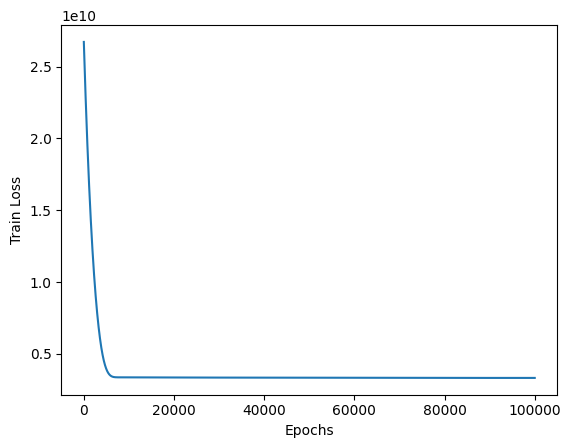

In [35]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

# Plot of stress–strain curve

In [36]:
# from handler.handleVisuals import plot_result_graph
#
# oedo_para = {
#         "max_n": 48,
#         "e_0": e_0,
#         "C_c": C_c,
#         "delta_epsilon": delta_epsilon,
#         "sigma_t": -1,
#     }
#
# oedo = Oedometer(**oedo_para)
#
# e_s_list, delta_sigma_list = plot_result_graph(model=model, oedo=oedo,iterations=oedo_para["max_n"])

In [38]:
# from handler.handleVisuals import plot_result_dataframe
# from IPython.display import Markdown, display
#
# plot_result_dataframe(pd, e_s_list, delta_sigma_list)